In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import pandas as pd 
import numpy as np 
import re,string
from bs4 import BeautifulSoup

In [3]:
from nltk import sent_tokenize, word_tokenize
from nltk import bigrams, trigrams
from nltk import WordNetLemmatizer

from nltk.util import ngrams, pad_sequence
from collections import Counter, defaultdict
from nltk.corpus import stopwords

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import losses
from tensorflow.keras import backend
from tensorflow.keras import callbacks

In [19]:
ftrain=open("train.txt", "r",encoding="utf-8")
text_raw = ftrain.read()

In [20]:
len(text_raw)

5034054

In [21]:
text_raw = text_raw[:500000]

In [22]:
def prepare_text(text_raw):
    text = text_raw
    # replace \n characters with space
    text=re.sub('\n',' ',text)
    # remove html tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()  
    # convert to lower case
    text = text.lower()

    text_sents = sent_tokenize(text)

    all_tokens = []
    text_sents_cleaned = []
    tokenized_word_sents = []
    for s in text_sents:
        s_cleaned = re.sub("[^a-zA-Z]", " ", s)
        s_words = word_tokenize(s_cleaned)
        for t in s_words:
            all_tokens.append(t)
        if(len(s_words) > 0):
            text_sents_cleaned.append(s_cleaned)
            tokenized_word_sents.append(s_words)

    all_tokens.append('none')
    all_tokens.append('None')
    all_tokens.append('<s>')
    all_tokens.append('</s>')

    print("len of all sentences: ",len(tokenized_word_sents))
    print("len of all tokens: ",len(all_tokens))
    return all_tokens, text_sents_cleaned, tokenized_word_sents

In [23]:
all_tokens, text_sents_cleaned, tokenized_word_sents = prepare_text(text_raw)

len of all sentences:  4371
len of all tokens:  84337


In [24]:
# sample sentence

print("first sentence:\n" , text_sents_cleaned[0])
s_words = word_tokenize(text_sents_cleaned[0])
print("\nwords of first sentence:\n" , s_words)
s_padded = pad_sequence(s_words,pad_left=True,left_pad_symbol="<s>",pad_right=True,right_pad_symbol="</s>",n=2)
print("\npadded words of first sentence:\n" , list(s_padded))


first sentence:
 many are the hours in which i have pondered upon the story that is set forth in the following pages 

words of first sentence:
 ['many', 'are', 'the', 'hours', 'in', 'which', 'i', 'have', 'pondered', 'upon', 'the', 'story', 'that', 'is', 'set', 'forth', 'in', 'the', 'following', 'pages']

padded words of first sentence:
 ['<s>', 'many', 'are', 'the', 'hours', 'in', 'which', 'i', 'have', 'pondered', 'upon', 'the', 'story', 'that', 'is', 'set', 'forth', 'in', 'the', 'following', 'pages', '</s>']


In [25]:
def build_encoder(all_tokens):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(all_tokens)
    #vocab_size = len(label_encoder.classes_)
    #print("vocab_size: ", vocab_size)

    # binary encode
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

    onehot_encoder = OneHotEncoder(sparse=False, dtype='uint8')
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return label_encoder, onehot_encoder


In [26]:
label_encoder, onehot_encoder = build_encoder(all_tokens)

vocab_size = len(label_encoder.classes_)
print("vocab_size: ", vocab_size)

# invert first example
print("invert of code 4: ", label_encoder.inverse_transform([4]))
print("transform of word \"the\" to code: ", label_encoder.transform(["the"]))
d = onehot_encoder.transform([label_encoder.transform(["the"])])
print("one-hot vector of word \"the\": ", d[0])

vocab_size:  12849
invert of code 4:  ['aa']
transform of word "the" to code:  [11449]
one-hot vector of word "the":  [0 0 0 ... 0 0 0]


In [27]:
def generate_index_ngram_X_Y(onehot_encoder, label_encoder, tokenized_word_sents):
    X = []
    Y = []
    count = 0
    countError = 0
    for sentence in tokenized_word_sents:    
        #s_padded = pad_sequence(sentence,pad_left=True,left_pad_symbol="<s>",pad_right=True,right_pad_symbol="</s>",n=2)
        for w1, w2, w3, w4, w5 in ngrams(sentence, pad_right=False, pad_left=False,n=5):
            count += 1
            #print(w1, w2, w3, w4, w5)
            try:
                x_w1 = str(w1).lower()
                index_x_w1 = [label_encoder.transform([str(w1).lower()])]
                index_x_w2 = [label_encoder.transform([str(w2).lower()])]
                index_x_w3 = [label_encoder.transform([str(w3).lower()])]
                index_x_w4 = [label_encoder.transform([str(w4).lower()])]
                index_y_w5 = [label_encoder.transform([str(w5).lower()])]
                X.append(index_x_w1 + index_x_w2 + index_x_w3 + index_x_w4)            
                Y.append(index_y_w5)
            except:
                print('Error during get vector for:{} {} {} {} {}'.format(w1, w2, w3, w4, w5))
                countError+=1
                pass
    print("count of 5-grams={}".format(count))        
    print("count on unknown 5-grams={}".format(countError)) 
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [28]:
X, Y = generate_index_ngram_X_Y(onehot_encoder, label_encoder, tokenized_word_sents)

count of 5-grams=67002
count on unknown 5-grams=0


In [29]:
ftest=open("test.txt", "r",encoding="utf-8")
test_text_raw = ftest.read()
test_all_tokens, test_text_sents_cleaned, test_tokenized_word_sents = prepare_text(test_text_raw)

len of all sentences:  992
len of all tokens:  20031


In [30]:
X_test, Y_test = generate_index_ngram_X_Y(onehot_encoder, label_encoder, test_tokenized_word_sents)

Error during get vector for:are not altogether at odds
Error during get vector for:yet there is a perpetual
Error during get vector for:there is a perpetual combat
Error during get vector for:is a perpetual combat going
Error during get vector for:a perpetual combat going on
Error during get vector for:perpetual combat going on between
Error during get vector for:of character and the tyranny
Error during get vector for:character and the tyranny of
Error during get vector for:and the tyranny of circumstance
Error during get vector for:the tyranny of circumstance death
Error during get vector for:tyranny of circumstance death and
Error during get vector for:of circumstance death and sin
Error during get vector for:the midst of the strife
Error during get vector for:midst of the strife the
Error during get vector for:of the strife the longing
Error during get vector for:the strife the longing and
Error during get vector for:strife the longing and the
Error during get vector for:the longin

Error during get vector for:the intellectual wrestlings of the
Error during get vector for:intellectual wrestlings of the world
Error during get vector for:wrestlings of the world the
Error during get vector for:of the world the thinkers
Error during get vector for:the world the thinkers poets
Error during get vector for:world the thinkers poets sages
Error during get vector for:the thinkers poets sages the
Error during get vector for:thinkers poets sages the victors
Error during get vector for:poets sages the victors in
Error during get vector for:sages the victors in great
Error during get vector for:the victors in great sorrows
Error during get vector for:victors in great sorrows who
Error during get vector for:desolation of spirit which arise
Error during get vector for:of spirit which arise from
Error during get vector for:spirit which arise from heroic
Error during get vector for:which arise from heroic human
Error during get vector for:arise from heroic human grief
Error during 

Error during get vector for:when we dive down into
Error during get vector for:we dive down into the
Error during get vector for:dive down into the deep
Error during get vector for:and swim of sea grasses
Error during get vector for:swim of sea grasses and
Error during get vector for:of sea grasses and currents
Error during get vector for:sea grasses and currents of
Error during get vector for:grasses and currents of flowing
Error during get vector for:and currents of flowing waves
Error during get vector for:currents of flowing waves that
Error during get vector for:of flowing waves that lap
Error during get vector for:flowing waves that lap about
Error during get vector for:waves that lap about the
Error during get vector for:that lap about the body
Error during get vector for:lap about the body with
Error during get vector for:a cool chill of palpitating
Error during get vector for:cool chill of palpitating color
Error during get vector for:chill of palpitating color that
Error duri

Error during get vector for:to rise above heredity is
Error during get vector for:rise above heredity is to
Error during get vector for:above heredity is to rise
Error during get vector for:heredity is to rise above
Error during get vector for:not escaping the special sin
Error during get vector for:escaping the special sin of
Error during get vector for:the special sin of one
Error during get vector for:special sin of one ancestor
Error during get vector for:sin of one ancestor but
Error during get vector for:of one ancestor but the
Error during get vector for:one ancestor but the sin
Error during get vector for:ancestor but the sin of
Error during get vector for:but the sin of all
Error during get vector for:the sin of all ancestors
Error during get vector for:race to be the culmination
Error during get vector for:to be the culmination of
Error during get vector for:be the culmination of virtue
Error during get vector for:the culmination of virtue until
Error during get vector for:cu

Error during get vector for:victor in the great combats
Error during get vector for:in the great combats of
Error during get vector for:the great combats of the
Error during get vector for:great combats of the race
Error during get vector for:for it nothing too distasteful
Error during get vector for:it nothing too distasteful nothing
Error during get vector for:nothing too distasteful nothing too
Error during get vector for:too distasteful nothing too insignificant
Error during get vector for:course of duty it spurs
Error during get vector for:of duty it spurs one
Error during get vector for:duty it spurs one to
Error during get vector for:it spurs one to do
Error during get vector for:spurs one to do one
Error during get vector for:this is the indwelling holy
Error during get vector for:is the indwelling holy spirit
Error during get vector for:the indwelling holy spirit wherein
Error during get vector for:indwelling holy spirit wherein is
Error during get vector for:holy spirit where

Error during get vector for:to the island of keras
Error during get vector for:the island of keras and
Error during get vector for:island of keras and receive
Error during get vector for:of keras and receive the
Error during get vector for:keras and receive the last
Error during get vector for:complete the pipe of pirra
Error during get vector for:marsh award for public sculpture
Error during get vector for:for public sculpture uk fadil
Error during get vector for:public sculpture uk fadil i
Error during get vector for:sculpture uk fadil i mazindarani
Error during get vector for:uk fadil i mazindarani visited
Error during get vector for:fadil i mazindarani visited in
Error during get vector for:i mazindarani visited in and
Error during get vector for:workforce was more than predominantly
Error during get vector for:was more than predominantly employed
Error during get vector for:more than predominantly employed in
Error during get vector for:than predominantly employed in technology
Er

Error during get vector for:lacewings giant lacewings may be
Error during get vector for:giant lacewings may be phytophagous
Error during get vector for:magical dynasty of the bamberg
Error during get vector for:dynasty of the bamberg s
Error during get vector for:the street assaulted them verbally
Error during get vector for:street assaulted them verbally and
Error during get vector for:assaulted them verbally and physically
Error during get vector for:the serbian rock band ekatarina
Error during get vector for:serbian rock band ekatarina velika
Error during get vector for:rock band ekatarina velika released
Error during get vector for:band ekatarina velika released in
Error during get vector for:chaos reign she personally descends
Error during get vector for:reign she personally descends to
Error during get vector for:she personally descends to el
Error during get vector for:personally descends to el sallia
Error during get vector for:descends to el sallia to
Error during get vector 

Error during get vector for:his humanity overtakes his thirst
Error during get vector for:humanity overtakes his thirst for
Error during get vector for:overtakes his thirst for revenge
Error during get vector for:april the whole town celebrated
Error during get vector for:the whole town celebrated the
Error during get vector for:whole town celebrated the production
Error during get vector for:town celebrated the production of
Error during get vector for:celebrated the production of the
Error during get vector for:big tex has suffered a
Error during get vector for:tex has suffered a few
Error during get vector for:suffered a few garment mishaps
Error during get vector for:a few garment mishaps over
Error during get vector for:few garment mishaps over the
Error during get vector for:garment mishaps over the years
Error during get vector for:t over until the fat
Error during get vector for:over until the fat man
Error during get vector for:until the fat man sings
Error during get vector f

Error during get vector for:district of kurigram which lies
Error during get vector for:of kurigram which lies on
Error during get vector for:kurigram which lies on the
Error during get vector for:yrigoyen however only obtained of
Error during get vector for:only obtained of the votes
Error during get vector for:obtained of the votes which
Error during get vector for:of the votes which did
Error during get vector for:the votes which did not
Error during get vector for:votes which did not allow
Error during get vector for:choice of the songs nobody
Error during get vector for:of the songs nobody else
Error during get vector for:the songs nobody else but
Error during get vector for:songs nobody else but me
Error during get vector for:nobody else but me and
Error during get vector for:and day dream was daring
Error during get vector for:day dream was daring but
Error during get vector for:dream was daring but she
Error during get vector for:was daring but she needed
Error during get vecto

Error during get vector for:independent italian designer mario maggi
Error during get vector for:italian designer mario maggi who
Error during get vector for:designer mario maggi who then
Error during get vector for:mario maggi who then gained
Error during get vector for:maggi who then gained the
Error during get vector for:financial backing of the elka
Error during get vector for:backing of the elka company
Error during get vector for:of the elka company of
Error during get vector for:the elka company of italy
Error during get vector for:elka company of italy who
Error during get vector for:italy who produced the synthesizer
Error during get vector for:who produced the synthesizer from
Error during get vector for:produced the synthesizer from to
Error during get vector for:is killed by his mog
Error during get vector for:killed by his mog enhancements
Error during get vector for:tompkins avenue was a station
Error during get vector for:demolished section of the bmt
Error during get ve

Error during get vector for:juvenile teams who have fared
Error during get vector for:teams who have fared much
Error during get vector for:who have fared much better
Error during get vector for:use of these categories reduces
Error during get vector for:of these categories reduces the
Error during get vector for:these categories reduces the likelihood
Error during get vector for:categories reduces the likelihood of
Error during get vector for:the likelihood of category mistakes
Error during get vector for:likelihood of category mistakes nonsensical
Error during get vector for:of category mistakes nonsensical contradictions
Error during get vector for:category mistakes nonsensical contradictions and
Error during get vector for:mistakes nonsensical contradictions and wasteful
Error during get vector for:nonsensical contradictions and wasteful duplication
Error during get vector for:contradictions and wasteful duplication in
Error during get vector for:and wasteful duplication in educolo

Error during get vector for:or bearings which are commonly
Error during get vector for:bearings which are commonly stated
Error during get vector for:commonly stated in this notation
Error during get vector for:antidosis is used by the
Error during get vector for:by the author to depict
Error during get vector for:the author to depict himself
Error during get vector for:author to depict himself as
Error during get vector for:to depict himself as a
Error during get vector for:depict himself as a model
Error during get vector for:himself as a model citizen
Error during get vector for:as a model citizen and
Error during get vector for:a model citizen and a
Error during get vector for:model citizen and a contributor
Error during get vector for:citizen and a contributor to
Error during get vector for:and a contributor to the
Error during get vector for:a contributor to the city
Error during get vector for:contributor to the city state
Error during get vector for:soon belyayev became interes

Error during get vector for:the mourners removed the lid
Error during get vector for:mourners removed the lid and
Error during get vector for:removed the lid and were
Error during get vector for:the lid and were overjoyed
Error during get vector for:lid and were overjoyed to
Error during get vector for:people generate and evaluate evidence
Error during get vector for:generate and evaluate evidence in
Error during get vector for:and evaluate evidence in arguments
Error during get vector for:evaluate evidence in arguments that
Error during get vector for:evidence in arguments that are
Error during get vector for:in arguments that are biased
Error during get vector for:arguments that are biased towards
Error during get vector for:that are biased towards their
Error during get vector for:are biased towards their own
Error during get vector for:biased towards their own beliefs
Error during get vector for:their own beliefs and opinions
Error during get vector for:for example a significand of

Error during get vector for:the birthday of the monkey
Error during get vector for:birthday of the monkey god
Error during get vector for:of the monkey god is
Error during get vector for:the monkey god is celebrated
Error during get vector for:monkey god is celebrated annually
Error during get vector for:god is celebrated annually on
Error during get vector for:is celebrated annually on the
Error during get vector for:celebrated annually on the th
Error during get vector for:annually on the th or
Error during get vector for:day of the first lunar
Error during get vector for:of the first lunar month
Error during get vector for:him direction toward spiritual fulfillment
Error during get vector for:direction toward spiritual fulfillment but
Error during get vector for:toward spiritual fulfillment but none
Error during get vector for:spiritual fulfillment but none were
Error during get vector for:fulfillment but none were found
Error during get vector for:the kerry slug was described
Error

Error during get vector for:analysis is available in joshi
Error during get vector for:is available in joshi schabes
Error during get vector for:the coal is the badlees
Error during get vector for:coal is the badlees first
Error during get vector for:is the badlees first full
Error during get vector for:the badlees first full length
Error during get vector for:badlees first full length album
Error during get vector for:film frozen by actor santino
Error during get vector for:frozen by actor santino fontana
Error during get vector for:a peristome can be present
Error during get vector for:peristome can be present but
Error during get vector for:present but often the lip
Error during get vector for:but often the lip is
Error during get vector for:often the lip is not
Error during get vector for:the lip is not thickened
Error during get vector for:lip is not thickened nor
Error during get vector for:the off season the sta
Error during get vector for:peucephila is a genus of
Error during g

Error during get vector for:won the war against ravana
Error during get vector for:the war against ravana and
Error during get vector for:war against ravana and brought
Error during get vector for:against ravana and brought back
Error during get vector for:ravana and brought back sita
Error during get vector for:and brought back sita devi
Error during get vector for:brought back sita devi from
Error during get vector for:back sita devi from sri
Error during get vector for:sita devi from sri lanka
Error during get vector for:referred him to the parliamentary
Error during get vector for:him to the parliamentary privileges
Error during get vector for:to the parliamentary privileges committee
Error during get vector for:the parliamentary privileges committee alleging
Error during get vector for:parliamentary privileges committee alleging contempt
Error during get vector for:privileges committee alleging contempt of
Error during get vector for:committee alleging contempt of parliament
Error

Error during get vector for:mounted and filed lichen collections
Error during get vector for:and filed lichen collections in
Error during get vector for:filed lichen collections in the
Error during get vector for:lichen collections in the herbarium
Error during get vector for:collections in the herbarium at
Error during get vector for:in the herbarium at the
Error during get vector for:the herbarium at the smithsonian
Error during get vector for:herbarium at the smithsonian institution
Error during get vector for:at the smithsonian institution department
Error during get vector for:the smithsonian institution department of
Error during get vector for:smithsonian institution department of botany
Error during get vector for:institution department of botany us
Error during get vector for:department of botany us loose
Error during get vector for:of botany us loose in
Error during get vector for:botany us loose in brown
Error during get vector for:loose in brown standard herbarium
Error dur

Error during get vector for:bells were restored for the
Error during get vector for:were restored for the millennium
Error during get vector for:restored for the millennium and
Error during get vector for:for the millennium and a
Error during get vector for:the millennium and a fairly
Error during get vector for:millennium and a fairly small
Error during get vector for:a bird like pubis arrangement
Error during get vector for:bird like pubis arrangement parallel
Error during get vector for:like pubis arrangement parallel to
Error during get vector for:pubis arrangement parallel to the
Error during get vector for:arrangement parallel to the vertebral
Error during get vector for:parallel to the vertebral column
Error during get vector for:to the vertebral column evolved
Error during get vector for:the vertebral column evolved independently
Error during get vector for:vertebral column evolved independently three
Error during get vector for:independently three times in dinosaur
Error durin

Error during get vector for:as the front spoiler a
Error during get vector for:the front spoiler a rear
Error during get vector for:front spoiler a rear wing
Error during get vector for:spoiler a rear wing a
Error during get vector for:wheel set and interior trim
Error during get vector for:platyptilia longalis is a moth
Error during get vector for:longalis is a moth of
Error during get vector for:a moth of the pterophoridae
Error during get vector for:moth of the pterophoridae family
Error during get vector for:according to the census ine
Error during get vector for:to the census ine the
Error during get vector for:the census ine the municipality
Error during get vector for:census ine the municipality has
Error during get vector for:ine the municipality has a
Error during get vector for:after the breweries combined operations
Error during get vector for:the breweries combined operations coastal
Error during get vector for:breweries combined operations coastal brewing
Error during get 

Error during get vector for:a group including karl rove
Error during get vector for:group including karl rove that
Error during get vector for:including karl rove that was
Error during get vector for:karl rove that was working
Error during get vector for:rove that was working to
Error during get vector for:that was working to discourage
Error during get vector for:was working to discourage those
Error during get vector for:working to discourage those they
Error during get vector for:to discourage those they deemed
Error during get vector for:discourage those they deemed unelectable
Error during get vector for:those they deemed unelectable conservative
Error during get vector for:they deemed unelectable conservative candidates
Error during get vector for:deemed unelectable conservative candidates to
Error during get vector for:unelectable conservative candidates to enable
Error during get vector for:likely conservative candidates to gain
Error during get vector for:conservative candidat

Error during get vector for:at the time ambassador carleton
Error during get vector for:the time ambassador carleton had
Error during get vector for:time ambassador carleton had procured
Error during get vector for:ambassador carleton had procured its
Error during get vector for:carleton had procured its suppression
Error during get vector for:had procured its suppression as
Error during get vector for:procured its suppression as a
Error during get vector for:its suppression as a libel
Error during get vector for:suppression as a libel by
Error during get vector for:as a libel by the
Error during get vector for:a libel by the states
Error during get vector for:libel by the states general
Error during get vector for:of the four issue miniseries
Error during get vector for:the four issue miniseries crossover
Error during get vector for:four issue miniseries crossover genesis
Error during get vector for:issue miniseries crossover genesis a
Error during get vector for:miniseries crossover 

Error during get vector for:small collection of buildings functioning
Error during get vector for:collection of buildings functioning independently
Error during get vector for:of buildings functioning independently of
Error during get vector for:buildings functioning independently of the
Error during get vector for:functioning independently of the public
Error during get vector for:time of the first hallucination
Error during get vector for:of the first hallucination s
Error during get vector for:the first hallucination s lasts
Error during get vector for:first hallucination s lasts from
Error during get vector for:hallucination s lasts from anywhere
Error during get vector for:s lasts from anywhere from
Error during get vector for:lasts from anywhere from five
Error during get vector for:simple truth is that remuneration
Error during get vector for:truth is that remuneration schemes
Error during get vector for:is that remuneration schemes have
Error during get vector for:that remunera

Error during get vector for:showed there is clinal north
Error during get vector for:there is clinal north south
Error during get vector for:is clinal north south variation
Error during get vector for:clinal north south variation but
Error during get vector for:north south variation but also
Error during get vector for:south variation but also the
Error during get vector for:variation but also the differentiation
Error during get vector for:but also the differentiation within
Error during get vector for:also the differentiation within the
Error during get vector for:the differentiation within the supposed
Error during get vector for:differentiation within the supposed subspecies
Error during get vector for:within the supposed subspecies is
Error during get vector for:the supposed subspecies is larger
Error during get vector for:supposed subspecies is larger than
Error during get vector for:subspecies is larger than that
Error during get vector for:thus does not warrant subspecies
Error

Error during get vector for:cheyenne sioux and arapaho warriors
Error during get vector for:sioux and arapaho warriors not
Error during get vector for:and arapaho warriors not wanting
Error during get vector for:arapaho warriors not wanting the
Error during get vector for:park is decorated with gothic
Error during get vector for:is decorated with gothic arcades
Error during get vector for:decorated with gothic arcades taken
Error during get vector for:with gothic arcades taken from
Error during get vector for:gothic arcades taken from the
Error during get vector for:arcades taken from the destroyed
Error during get vector for:the playing field of danuvia
Error during get vector for:playing field of danuvia zolt
Error during get vector for:field of danuvia zolt n
Error during get vector for:of danuvia zolt n varga
Error during get vector for:danuvia zolt n varga played
Error during get vector for:zolt n varga played in
Error during get vector for:n varga played in an
Error during get ve

Error during get vector for:until early in the arroyo
Error during get vector for:early in the arroyo administration
Error during get vector for:the ground floors are rusticated
Error during get vector for:ground floors are rusticated with
Error during get vector for:floors are rusticated with massive
Error during get vector for:are rusticated with massive pilasters
Error during get vector for:rusticated with massive pilasters and
Error during get vector for:with massive pilasters and the
Error during get vector for:massive pilasters and the piano
Error during get vector for:pilasters and the piano nobile
Error during get vector for:and the piano nobile above
Error during get vector for:the piano nobile above has
Error during get vector for:piano nobile above has windows
Error during get vector for:nobile above has windows with
Error during get vector for:has windows with substantial pediments
Error during get vector for:it is headquartered in philadelphia
Error during get vector for:s

Error during get vector for:for each of its municipalities
Error during get vector for:each of its municipalities which
Error during get vector for:of its municipalities which defines
Error during get vector for:its municipalities which defines how
Error during get vector for:municipalities which defines how far
Error during get vector for:which defines how far out
Error during get vector for:defines how far out services
Error during get vector for:such as water and sewer
Error during get vector for:as water and sewer will
Error during get vector for:water and sewer will go
Error during get vector for:this species occurs in the
Error during get vector for:species occurs in the pacific
Error during get vector for:occurs in the pacific ocean
Error during get vector for:the pacific ocean off panama
Error during get vector for:announcing the hall of fame
Error during get vector for:the hall of fame and
Error during get vector for:hall of fame and special
Error during get vector for:of fame

Error during get vector for:west side of shire ditch
Error during get vector for:side of shire ditch and
Error during get vector for:of shire ditch and frays
Error during get vector for:shire ditch and frays river
Error during get vector for:ditch and frays river and
Error during get vector for:and frays river and through
Error during get vector for:frays river and through the
Error during get vector for:centre of the present denham
Error during get vector for:of the present denham country
Error during get vector for:the present denham country park
Error during get vector for:the km sq mi cocopah
Error during get vector for:km sq mi cocopah indian
Error during get vector for:sq mi cocopah indian reservation
Error during get vector for:mi cocopah indian reservation which
Error during get vector for:cocopah indian reservation which is
Error during get vector for:indian reservation which is composed
Error during get vector for:reservation which is composed of
Error during get vector for:o

Error during get vector for:page who was originally slated
Error during get vector for:who was originally slated to
Error during get vector for:was originally slated to be
Error during get vector for:originally slated to be solely
Error during get vector for:slated to be solely the
Error during get vector for:his own on bass guitar
Error during get vector for:own on bass guitar the
Error during get vector for:on bass guitar the members
Error during get vector for:bass guitar the members decided
Error during get vector for:guitar the members decided to
Error during get vector for:decided to remain a fourpiece
Error during get vector for:since johnston went missing gaza
Error during get vector for:johnston went missing gaza reporters
Error during get vector for:went missing gaza reporters held
Error during get vector for:missing gaza reporters held another
Error during get vector for:gaza reporters held another strike
Error during get vector for:held another strike in solidarity
Error du

Error during get vector for:one of the princely states
Error during get vector for:of the princely states of
Error during get vector for:the princely states of india
Error during get vector for:princely states of india in
Error during get vector for:of india in the saurashtra
Error during get vector for:india in the saurashtra region
Error during get vector for:in the saurashtra region during
Error during get vector for:the saurashtra region during the
Error during get vector for:saurashtra region during the period
Error during get vector for:period of the british raj
Error during get vector for:in accordance with the medical
Error during get vector for:accordance with the medical wisdom
Error during get vector for:with the medical wisdom of
Error during get vector for:the medical wisdom of the
Error during get vector for:medical wisdom of the time
Error during get vector for:wisdom of the time he
Error during get vector for:he was treated with leeches
Error during get vector for:was t

Error during get vector for:also exhibited international work from
Error during get vector for:exhibited international work from africa
Error during get vector for:east and has received commissions
Error during get vector for:and has received commissions from
Error during get vector for:has received commissions from the
Error during get vector for:received commissions from the uk
Error during get vector for:commissions from the uk s
Error during get vector for:ran the summer theatre friluftsteatret
Error during get vector for:the summer theatre friluftsteatret at
Error during get vector for:summer theatre friluftsteatret at bygd
Error during get vector for:theatre friluftsteatret at bygd y
Error during get vector for:friluftsteatret at bygd y in
Error during get vector for:at bygd y in the
Error during get vector for:bygd y in the s
Error during get vector for:the s and the cabaret
Error during get vector for:s and the cabaret edderkoppen
Error during get vector for:and the cabaret edd

Error during get vector for:african native national congress sannc
Error during get vector for:native national congress sannc which
Error during get vector for:national congress sannc which would
Error during get vector for:congress sannc which would become
Error during get vector for:sannc which would become the
Error during get vector for:apart from being recommended in
Error during get vector for:from being recommended in the
Error during get vector for:being recommended in the united
Error during get vector for:recommended in the united states
Error during get vector for:states it is a recommended
Error during get vector for:it is a recommended read
Error during get vector for:is a recommended read for
Error during get vector for:a recommended read for insights
Error during get vector for:recommended read for insights in
Error during get vector for:read for insights in the
Error during get vector for:for insights in the personal
Error during get vector for:insights in the personal 

Error during get vector for:d and a specialised training
Error during get vector for:and a specialised training company
Error during get vector for:a specialised training company namur
Error during get vector for:specialised training company namur company
Error during get vector for:the passion of saint tibulus
Error during get vector for:passion of saint tibulus is
Error during get vector for:of saint tibulus is the
Error during get vector for:saint tibulus is the rd
Error during get vector for:tibulus is the rd episode
Error during get vector for:video was filmed at reseda
Error during get vector for:was filmed at reseda high
Error during get vector for:filmed at reseda high school
Error during get vector for:at reseda high school in
Error during get vector for:reseda high school in reseda
Error during get vector for:high school in reseda california
Error during get vector for:educational system was further enlarged
Error during get vector for:system was further enlarged and
Error du

Error during get vector for:shops in hong kong specializing
Error during get vector for:in hong kong specializing in
Error during get vector for:hong kong specializing in art
Error during get vector for:kong specializing in art books
Error during get vector for:indiaglitz in its review summarised
Error during get vector for:in its review summarised overall
Error during get vector for:its review summarised overall the
Error during get vector for:review summarised overall the trailer
Error during get vector for:summarised overall the trailer lives
Error during get vector for:lives up to the expectation
Error during get vector for:up to the expectation and
Error during get vector for:to the expectation and it
Error during get vector for:the expectation and it is
Error during get vector for:expectation and it is up
Error during get vector for:some verses of the yasna
Error during get vector for:verses of the yasna e
Error during get vector for:of the yasna e g
Error during get vector for:y

Error during get vector for:obtained timber from san domingo
Error during get vector for:timber from san domingo cuba
Error during get vector for:from san domingo cuba and
Error during get vector for:san domingo cuba and jamaica
Error during get vector for:domingo cuba and jamaica for
Error during get vector for:cuba and jamaica for building
Error during get vector for:and jamaica for building many
Error during get vector for:jamaica for building many ships
Error during get vector for:the radha are found mainly
Error during get vector for:radha are found mainly in
Error during get vector for:in the districts of kheri
Error during get vector for:the districts of kheri bahraich
Error during get vector for:districts of kheri bahraich pilibhit
Error during get vector for:of kheri bahraich pilibhit bareilly
Error during get vector for:kheri bahraich pilibhit bareilly shahjahanpur
Error during get vector for:bahraich pilibhit bareilly shahjahanpur sitapur
Error during get vector for:pilibhit

Error during get vector for:important works for solo piano
Error during get vector for:works for solo piano between
Error during get vector for:for solo piano between and
Error during get vector for:immediately after graduation from marquette
Error during get vector for:after graduation from marquette in
Error during get vector for:graduation from marquette in olszyk
Error during get vector for:from marquette in olszyk began
Error during get vector for:marquette in olszyk began his
Error during get vector for:in olszyk began his career
Error during get vector for:olszyk began his career in
Error during get vector for:in broadcast journalism at wtmj
Error during get vector for:broadcast journalism at wtmj am
Error during get vector for:the guiding light was alexander
Error during get vector for:guiding light was alexander macfarlane
Error during get vector for:light was alexander macfarlane who
Error during get vector for:was alexander macfarlane who served
Error during get vector for:a

Error during get vector for:muybridge used his system to
Error during get vector for:used his system to analyze
Error during get vector for:his system to analyze the
Error during get vector for:system to analyze the movements
Error during get vector for:to analyze the movements of
Error during get vector for:analyze the movements of a
Error during get vector for:as the curriculum progresses students
Error during get vector for:the curriculum progresses students will
Error during get vector for:curriculum progresses students will be
Error during get vector for:progresses students will be expected
Error during get vector for:a variety of topics incorporating
Error during get vector for:variety of topics incorporating a
Error during get vector for:of topics incorporating a more
Error during get vector for:topics incorporating a more varied
Error during get vector for:incorporating a more varied lexicon
Error during get vector for:a more varied lexicon and
Error during get vector for:more 

Error during get vector for:was a centenary event in
Error during get vector for:again in the minors shinners
Error during get vector for:in the minors shinners collected
Error during get vector for:the minors shinners collected averages
Error during get vector for:minors shinners collected averages of
Error during get vector for:shinners collected averages of and
Error during get vector for:collected averages of and retiring
Error during get vector for:averages of and retiring after
Error during get vector for:pheoby tells janie s story
Error during get vector for:tells janie s story to
Error during get vector for:janie s story to the
Error during get vector for:s story to the nosy
Error during get vector for:story to the nosy community
Error during get vector for:to the nosy community on
Error during get vector for:the nosy community on her
Error during get vector for:nosy community on her behalf
Error during get vector for:qualitatively a surface is positively
Error during get vecto

Error during get vector for:a controversial letter alleging that
Error during get vector for:controversial letter alleging that jean
Error during get vector for:letter alleging that jean schmidt
Error during get vector for:alleging that jean schmidt has
Error during get vector for:committees to deny the slaughter
Error during get vector for:to deny the slaughter of
Error during get vector for:deny the slaughter of million
Error during get vector for:the slaughter of million armenian
Error during get vector for:slaughter of million armenian men
Error during get vector for:finally the flier asserted that
Error during get vector for:the flier asserted that the
Error during get vector for:flier asserted that the claims
Error during get vector for:it contained could be adequately
Error during get vector for:contained could be adequately verified
Error during get vector for:could be adequately verified by
Error during get vector for:be adequately verified by a
Error during get vector for:ade

Error during get vector for:children s coaches and sleighs
Error during get vector for:in the categories he attempted
Error during get vector for:the categories he attempted to
Error during get vector for:categories he attempted to discern
Error during get vector for:advantage helped to keep usia
Error during get vector for:helped to keep usia enterprises
Error during get vector for:to keep usia enterprises afloat
Error during get vector for:keep usia enterprises afloat despite
Error during get vector for:usia enterprises afloat despite their
Error during get vector for:enterprises afloat despite their mounting
Error during get vector for:afloat despite their mounting obsolescence
Error during get vector for:of this short the carriage
Error during get vector for:this short the carriage continues
Error during get vector for:short the carriage continues to
Error during get vector for:the carriage continues to climb
Error during get vector for:carriage continues to climb a
Error during ge

Error during get vector for:audiences with schneerson during which
Error during get vector for:with schneerson during which they
Error during get vector for:schneerson during which they conversed
Error during get vector for:during which they conversed for
Error during get vector for:which they conversed for long
Error during get vector for:they conversed for long periods
Error during get vector for:conversed for long periods of
Error during get vector for:the florence series depicts for
Error during get vector for:florence series depicts for the
Error during get vector for:artists own family and workshop
Error during get vector for:own family and workshop drawn
Error during get vector for:family and workshop drawn direct
Error during get vector for:and workshop drawn direct from
Error during get vector for:workshop drawn direct from life
Error during get vector for:bring biotechnology to the forefront
Error during get vector for:biotechnology to the forefront of
Error during get vector

Error during get vector for:thriller in the sunday league
Error during get vector for:four day loss to nottinghamshire
Error during get vector for:dimitris diamantidis was named the
Error during get vector for:diamantidis was named the final
Error during get vector for:named the final four mvp
Error during get vector for:dutch language the word toko
Error during get vector for:language the word toko has
Error during get vector for:the word toko has become
Error during get vector for:word toko has become an
Error during get vector for:toko has become an informal
Error during get vector for:has become an informal name
Error during get vector for:become an informal name for
Error during get vector for:an informal name for any
Error during get vector for:informal name for any type
Error during get vector for:type of company or organisation
Error during get vector for:in diameter on mm peduncles
Error during get vector for:diameter on mm peduncles the
Error during get vector for:on mm pedun

Error during get vector for:judo competitions at the commonwealth
Error during get vector for:the commonwealth games in glasgow
Error during get vector for:commonwealth games in glasgow scotland
Error during get vector for:games in glasgow scotland was
Error during get vector for:in glasgow scotland was held
Error during get vector for:glasgow scotland was held on
Error during get vector for:a swiss annuity is not
Error during get vector for:swiss annuity is not considered
Error during get vector for:annuity is not considered a
Error during get vector for:not considered a european annuity
Error during get vector for:considered a european annuity for
Error during get vector for:a european annuity for tax
Error during get vector for:european annuity for tax reasons
Error during get vector for:features the work of avant
Error during get vector for:the work of avant garde
Error during get vector for:work of avant garde puppet
Error during get vector for:of avant garde puppet troupe
Error d

Error during get vector for:bernard devoto wrote a mixed
Error during get vector for:devoto wrote a mixed review
Error during get vector for:safemaker jacob h meyers created
Error during get vector for:jacob h meyers created the
Error during get vector for:h meyers created the automatic
Error during get vector for:meyers created the automatic voting
Error during get vector for:created the automatic voting machine
Error during get vector for:the automatic voting machine in
Error during get vector for:automatic voting machine in and
Error during get vector for:voting machine in and established
Error during get vector for:and established the automatic voting
Error during get vector for:established the automatic voting machine
Error during get vector for:the automatic voting machine corporation
Error during get vector for:automatic voting machine corporation avm
Error during get vector for:voting machine corporation avm in
Error during get vector for:gresvig was board member of
Error durin

Error during get vector for:a school town was dominant
Error during get vector for:school town was dominant in
Error during get vector for:town was dominant in eger
Error during get vector for:two cylinder simple non condensing
Error during get vector for:cylinder simple non condensing saturated
Error during get vector for:simple non condensing saturated american
Error during get vector for:non condensing saturated american rasprsquo
Error during get vector for:condensing saturated american rasprsquo type
Error during get vector for:saturated american rasprsquo type steam
Error during get vector for:out of over other entries
Error during get vector for:new papers on den yeniseian
Error during get vector for:papers on den yeniseian since
Error during get vector for:on den yeniseian since the
Error during get vector for:den yeniseian since the volume
Error during get vector for:yeniseian since the volume was
Error during get vector for:amduscias is also tasked with
Error during get vecto

Error during get vector for:rather that option is configured
Error during get vector for:that option is configured at
Error during get vector for:option is configured at the
Error during get vector for:is configured at the server
Error during get vector for:configured at the server level
Error during get vector for:elrington ball describes parker as
Error during get vector for:ball describes parker as an
Error during get vector for:describes parker as an extraordinary
Error during get vector for:parker as an extraordinary individual
Error during get vector for:modest beginning as a merchant
Error during get vector for:beginning as a merchant in
Error during get vector for:as a merchant in a
Error during get vector for:a merchant in a small
Error during get vector for:merchant in a small town
Error during get vector for:as sussex s successor nicholas
Error during get vector for:sussex s successor nicholas arnold
Error during get vector for:sweet echoes of this hymn
Error during get vect

Error during get vector for:the baku society of krishna
Error during get vector for:baku society of krishna consciousness
Error during get vector for:society of krishna consciousness they
Error during get vector for:of krishna consciousness they tend
Error during get vector for:krishna consciousness they tend to
Error during get vector for:to have short rounded wings
Error during get vector for:have short rounded wings and
Error during get vector for:short rounded wings and to
Error during get vector for:rounded wings and to be
Error during get vector for:wings and to be weak
Error during get vector for:and to be weak fliers
Error during get vector for:does not run on sundays
Error during get vector for:not run on sundays and
Error during get vector for:run on sundays and on
Error during get vector for:on sundays and on full
Error during get vector for:sundays and on full moon
Error during get vector for:the district removed several principals
Error during get vector for:district remov

Error during get vector for:asteroid was discovered on march
Error during get vector for:discovered on march by yrj
Error during get vector for:on march by yrj v
Error during get vector for:march by yrj v is
Error during get vector for:by yrj v is l
Error during get vector for:owned cameroon radio television crtv
Error during get vector for:cameroon radio television crtv operates
Error during get vector for:radio television crtv operates both
Error during get vector for:television crtv operates both a
Error during get vector for:crtv operates both a tv
Error during get vector for:forwarding to video processing could
Error during get vector for:take advantage of the efficiency
Error during get vector for:advantage of the efficiency of
Error during get vector for:of the efficiency of stream
Error during get vector for:the efficiency of stream processing
Error during get vector for:one of his proudest moments
Error during get vector for:of his proudest moments was
Error during get vector 

Error during get vector for:on chip except the latticemico
Error during get vector for:chip except the latticemico core
Error during get vector for:except the latticemico core were
Error during get vector for:the latticemico core were custom
Error during get vector for:latticemico core were custom developed
Error during get vector for:and placed under the gnu
Error during get vector for:placed under the gnu gpl
Error during get vector for:under the gnu gpl license
Error during get vector for:appointments of u s postmasters
Error during get vector for:of u s postmasters register
Error during get vector for:u s postmasters register george
Error during get vector for:s postmasters register george drum
Error during get vector for:postmasters register george drum son
Error during get vector for:george drum son of abraham
Error during get vector for:drum son of abraham was
Error during get vector for:son of abraham was appointed
Error during get vector for:of abraham was appointed on
Error d

Error during get vector for:paved shoulders to piekenierskloof pass
Error during get vector for:shoulders to piekenierskloof pass near
Error during get vector for:to piekenierskloof pass near citrusdal
Error during get vector for:piekenierskloof pass near citrusdal only
Error during get vector for:pass near citrusdal only a
Error during get vector for:near citrusdal only a short
Error during get vector for:citrusdal only a short km
Error during get vector for:short km section through malmesbury
Error during get vector for:km section through malmesbury attains
Error during get vector for:section through malmesbury attains freeway
Error during get vector for:through malmesbury attains freeway status
Error during get vector for:malmesbury attains freeway status again
Error during get vector for:attains freeway status again along
Error during get vector for:species within the genus dyraspis
Error during get vector for:within the genus dyraspis include
Error during get vector for:the genus 

Error during get vector for:under under a co operative
Error during get vector for:under a co operative agreement
Error during get vector for:the multijet power introduced in
Error during get vector for:multijet power introduced in saw
Error during get vector for:the height of the nasserite
Error during get vector for:height of the nasserite era
Error during get vector for:of the nasserite era to
Error during get vector for:the nasserite era to about
Error during get vector for:nasserite era to about of
Error during get vector for:full thrust of al infitah
Error during get vector for:thrust of al infitah in
Error during get vector for:of al infitah in the
Error during get vector for:al infitah in the early
Error during get vector for:infitah in the early s
Error during get vector for:morrison was seen as the
Error during get vector for:was seen as the favourite
Error during get vector for:seen as the favourite by
Error during get vector for:as the favourite by many
Error during get vec

Error during get vector for:and the robotic doll attacks
Error during get vector for:the robotic doll attacks him
Error during get vector for:the liner notes were written
Error during get vector for:liner notes were written by
Error during get vector for:were written by dr demento
Error during get vector for:let micrornas reduce the expression
Error during get vector for:micrornas reduce the expression of
Error during get vector for:the expression of pro reprogramming
Error during get vector for:expression of pro reprogramming genes
Error during get vector for:of pro reprogramming genes via
Error during get vector for:pro reprogramming genes via rna
Error during get vector for:reprogramming genes via rna interference
Error during get vector for:of world war i hansa
Error during get vector for:world war i hansa was
Error during get vector for:war i hansa was mobilized
Error during get vector for:i hansa was mobilized into
Error during get vector for:hansa was mobilized into the
Error du

Error during get vector for:lucas tells toadie that his
Error during get vector for:tells toadie that his apprentice
Error during get vector for:toadie that his apprentice chris
Error during get vector for:that his apprentice chris pappas
Error during get vector for:his apprentice chris pappas james
Error during get vector for:apprentice chris pappas james mason
Error during get vector for:chris pappas james mason has
Error during get vector for:pappas james mason has been
Error during get vector for:james mason has been attacked
Error during get vector for:mason has been attacked and
Error during get vector for:has been attacked and toadie
Error during get vector for:been attacked and toadie is
Error during get vector for:attacked and toadie is taken
Error during get vector for:and toadie is taken to
Error during get vector for:toadie is taken to the
Error during get vector for:flughafen became an official city
Error during get vector for:academic performance tends to vary
Error durin

Error during get vector for:the vampire diaries and the
Error during get vector for:vampire diaries and the th
Error during get vector for:diaries and the th episode
Error during get vector for:uk had caused considerable disruption
Error during get vector for:had caused considerable disruption to
Error during get vector for:caused considerable disruption to shipping
Error during get vector for:considerable disruption to shipping schedules
Error during get vector for:disruption to shipping schedules in
Error during get vector for:to shipping schedules in the
Error during get vector for:shipping schedules in the spring
Error during get vector for:schedules in the spring of
Error during get vector for:many crossings to be cancelled
Error during get vector for:was the home of maybelle
Error during get vector for:the home of maybelle addington
Error during get vector for:home of maybelle addington carter
Error during get vector for:of maybelle addington carter who
Error during get vector fo

In [31]:
#print(history.history['val_perplexity'])
def perplexity(y_true, y_pred):
    cross_entropy = losses.categorical_crossentropy(y_true, y_pred)
    perplexity = backend.pow(2.0, cross_entropy)
    return perplexity

In [32]:
from tensorflow.keras.optimizers import SGD

def build_model(input_dim, vocab_size, embedding_size, hidden_units, learning_rate):
    model = Sequential()
    model.add(Dense(embedding_size*4, input_dim=input_dim, activation='tanh'))
    model.add(Dense(hidden_units, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(vocab_size, activation='softmax'))
    sgd = SGD(lr=learning_rate, momentum=0., decay=0., nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[perplexity])
    return model

In [33]:
class ReportCallback(callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        print("Epoch {}: perplexity={}, loss={}, val_perplexity={}, val_loss={},".format(
                epoch, logs["perplexity"], logs["loss"], logs["val_perplexity"], logs["val_loss"]))

In [34]:
import random 
def generator_onehot(features, labels, input_size, vocab_size, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, input_size))
    batch_labels = np.zeros((batch_size,vocab_size))
    while True:
        for i in range(batch_size):
            index = random.randrange(len(features))
            w1= np.array(int(features[index][0]))
            w1_oh = onehot_encoder.transform(w1.reshape(-1, 1))
            
            w2= np.array(int(features[index][1]))
            w2_oh = onehot_encoder.transform(w2.reshape(-1, 1))
            
            w3= np.array(int(features[index][2]))
            w3_oh = onehot_encoder.transform(w3.reshape(-1, 1))
            
            w4= np.array(int(features[index][3]))
            w4_oh = onehot_encoder.transform(w4.reshape(-1, 1))
            
            w5= np.array(int(labels[index][0]))
            w5_oh = onehot_encoder.transform(w5.reshape(-1, 1))
            
            batch_features[i] = list(w1_oh[0]) + list(w2_oh[0]) + list(w3_oh[0]) + list(w4_oh[0])
            batch_labels[i] = list(w5_oh[0])
        yield batch_features, batch_labels

In [39]:
num_train_5grams = len(X)
num_test_5grams = len(X_test)
print("num_train_5grams:", num_train_5grams)
print("num_test_5grams:", num_test_5grams)
input_size = vocab_size * 4
print("input_size:", input_size)
print("vocab_size:", vocab_size)
batch_size = 32
steps_per_epoch = int(num_train_5grams/batch_size)
validation_steps = int(num_test_5grams/batch_size)
print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

num_train_5grams: 67002
num_test_5grams: 7999
input_size: 51396
vocab_size: 12849
steps_per_epoch: 2093
validation_steps: 249


In [40]:
model = build_model(input_size, vocab_size,embedding_size=50, hidden_units=35, learning_rate=0.2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               10279400  
_________________________________________________________________
dense_4 (Dense)              (None, 35)                7035      
_________________________________________________________________
dense_5 (Dense)              (None, 12849)             462564    
Total params: 10,748,999
Trainable params: 10,748,999
Non-trainable params: 0
_________________________________________________________________


In [41]:
def train_model(model, model_filepath, pretrained_weights, epoch_num):
    if (pretrained_weights == True):
        model.load_weights(model_filepath)
    #--------------------------------------
    checkpointer = ModelCheckpoint(model_filepath, monitor='val_perplexity', verbose=1, save_best_only=True, mode='min')
    metrics = model.fit_generator(generator_onehot(X, Y, input_size, vocab_size, batch_size),
                                  steps_per_epoch=100, 
                                  validation_data=generator_onehot(X_test, Y_test, input_size, vocab_size, batch_size),
                                  validation_steps=15,
                                  epochs=epoch_num, verbose=0, callbacks=[ReportCallback(),checkpointer], 
                                  workers=10,shuffle=True)
    
    return metrics

In [42]:
model_filepath = 'model_lm_5w_35n_lr_2_onehot.hdf5'
metrics = train_model(model, model_filepath, pretrained_weights=False, epoch_num=25)

Epoch 0: perplexity=548.9824398803711, loss=8.527759156227113, val_perplexity=530.5936604817708, val_loss=7.900961621602376,

Epoch 00001: val_perplexity improved from inf to 530.59366, saving model to model_lm_5w_35n_lr_2_onehot.hdf5
Epoch 1: perplexity=516.3408834838867, loss=7.6899012136459355, val_perplexity=503.8187764485677, val_loss=7.369813601175944,

Epoch 00002: val_perplexity improved from 530.59366 to 503.81878, saving model to model_lm_5w_35n_lr_2_onehot.hdf5
Epoch 2: perplexity=500.70762786865237, loss=7.502414622306824, val_perplexity=491.13359375, val_loss=7.2607421875,

Epoch 00003: val_perplexity improved from 503.81878 to 491.13359, saving model to model_lm_5w_35n_lr_2_onehot.hdf5
Epoch 3: perplexity=493.36376098632815, loss=7.315544266700744, val_perplexity=516.0157104492188, val_loss=7.226464875539144,

Epoch 00004: val_perplexity did not improve from 491.13359
Epoch 4: perplexity=475.3161994934082, loss=7.171100096702576, val_perplexity=503.2476786295573, val_loss

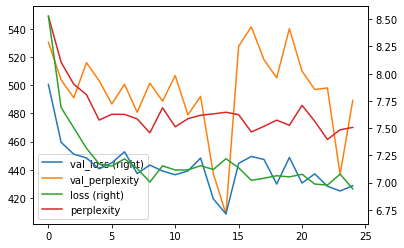

In [43]:
result = pd.DataFrame.from_dict(metrics.history)
result.plot.line(secondary_y=["loss", "val_loss"])

In [44]:
perp_trfile = open('perp_train_lm_5w_35n_lr_2_onehot.csv', "ab")    
np.savetxt(perp_trfile, metrics.history.get('perplexity'), fmt="%2.6f",delimiter=",")
perp_trfile.close()

In [45]:
perp_tsfile = open('perp_test_lm_5w_35n_lr_2_onehot.csv', "ab")    
np.savetxt(perp_tsfile, metrics.history.get('val_perplexity'), fmt="%2.6f",delimiter=",")
perp_tsfile.close()

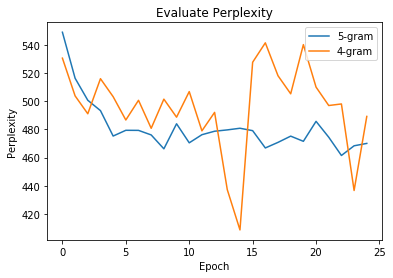

In [46]:
import matplotlib.pyplot as plt
import numpy as np

train_perp1 = np.loadtxt('perp_train_lm_5w_35n_lr_2_onehot.csv', delimiter=',')
train_perp2 = np.loadtxt('perp_test_lm_5w_35n_lr_2_onehot.csv', delimiter=',')

x = np.array(range(len(train_perp1)))

# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, train_perp1, color='tab:blue', label='5-gram')
ax.plot(x, train_perp2, color='tab:orange', label='4-gram')

ax.set_title("Evaluate Perplexity")
ax.set_xlabel('Epoch')
ax.set_ylabel('Perplexity')
plt.legend(loc="upper right")
plt.show()